# 1. Zadatak

U prvom zadatku je traženo da se napravi green screen od kraljičine haljine. Moja ideja za izradu ovog zadatka je da iz rgb kolor sistema pređem u hsv kako bih dobio informaciju o boji i saturaciji i na taj način napravio masku. Nakon Toga kako bih zadržao informaciju o osvetljenosti i kako bih lakše mogao da prenesem boje čija je saturacija jako mala (crna), prebacio sam u yuv kolor sistem. Na taj način manipulacijom nad komponentama u i v sam ubacio željenu sliku na mestu maske.

In [1]:
from pylab import *
import matplotlib.pyplot as plt
import skimage
from skimage import color
from skimage import exposure
from skimage import filters
from skimage import io
from pylab import *
from pylab import *
import imageio
from scipy import ndimage
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np

Ulazna slika izgleda ovako:

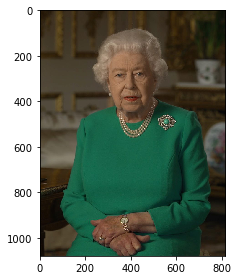

In [2]:
imgQueen = imread('queen_dress.jpg')

io.imshow(imgQueen)

Kada prebacim sliku iz RGB kolor sistema u YUV ovako izgledaju svaka od komponenti slike u HSV formatu.

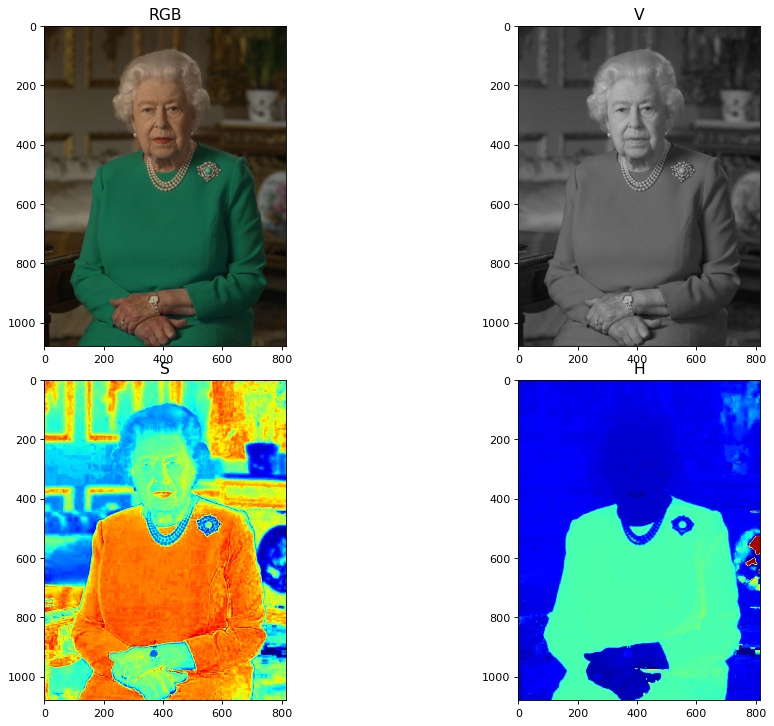

In [3]:
imgQueenHSV = color.rgb2hsv(imgQueen)
fig, ax = plt.subplots(2, 2, figsize=(12,9), dpi=80);
tight_layout();
ax[0,0].imshow(imgQueen); ax[0,0].set_title('RGB', fontsize=14);
ax[0,1].imshow(imgQueenHSV[:,:,2], vmin=0, vmax=1, cmap='gray'); ax[0,1].set_title('V', fontsize=14);
ax[1,0].imshow(imgQueenHSV[:,:,1], vmin=0, vmax=1, cmap='jet'); ax[1,0].set_title('S', fontsize=14);
ax[1,1].imshow(imgQueenHSV[:,:,0], vmin=0, vmax=1, cmap='jet'); ax[1,1].set_title('H', fontsize=14);

Za obradu slike, a i snimka koristio sam sledeću funkciju. Drugu sliku sam ubacivao u YUV formatu, jer mi je taj kolor sistem potreban za dodavanje slike. Unosim taj format slike kako bih uštedeo vreme i ne radim svaki put prebacivanje u YUV kolor sistem za svaki frame (kasnije kada dođe do obrade snimka).

In [4]:
def dressQueen(rgbQueen: np.array, yuvImg: np.array) -> np.array:
    # prebacivanje u HSV i YUV kolor sistem
    imgQueenHSV = color.rgb2hsv(rgbQueen)
    imgQueenYUV = color.rgb2yuv(rgbQueen)
    # skaliranje Y komponente kako bih mogao da skaliram Y komponentu druge slike
    yComp = imgQueenYUV[:,:,0]/np.max(imgQueenYUV[:,:,0])
    size1 = rgbQueen.shape
    
    # pravljenje maske na osnovu vrednosti boje i saturacije
    mask = (imgQueenHSV[:,:,0]>0.2) & (imgQueenHSV[:,:,0]<0.5) & (imgQueenHSV[:,:,1]>=0.5)
    
    # množim sa vrednostima saturacije kako bih dobio što manje vrednosti za one delove slike koji su se "provukli"
    mask = mask*imgQueenHSV[:,:,1]
    # filtriranje gausovim filtrom kako bih smanjio komponente van haljine
    mask_gauss = filters.gaussian(mask, sigma=10, truncate=2)
    
    # pravljenje nvrednosti koje treba da se ubace umesto haljine
    newY = imgYUV[0:size1[0],0:size1[1],0]
    newU = imgYUV[0:size1[0],0:size1[1],1]
    newV = imgYUV[0:size1[0],0:size1[1],2]
    
    # konacno pravljenje maske za haljinu
    mask1 = mask_gauss>0.6
    
    # za sve frame-ove koji imaju manje od 10000 piksela umesto kojih treba staviti drugu sliku treba da se odbace,
    # jer je to premali broj piksela i to su frame-ovi gde se kraljica uopšte ne nalazi.
    if np.sum(mask1)<10000:
        return rgbQueen
    
    # stavljanje druge slike umesto haljine
    imgQueenYUV[mask1,0] = newY[mask1]*yComp[mask1]
    imgQueenYUV[mask1,1] = newU[mask1]
    imgQueenYUV[mask1,2] = newV[mask1]
    
    # vracanje u RGB kolor sistem
    imgQueenOutput = color.yuv2rgb(imgQueenYUV)
    
    return imgQueenOutput

Testiranje funkcije nad slikom.

# 3. zadatak

U ovom zadatku je potrebno uraditi CLAHE obradu slike. CLAHE zahteva nekoliko koraka, a to su: podela slike na blokove, pravljenje histograma (funkciju gustinu verovatnoće) za svaki od blokova, ograničavanje histograma, pravljenje funkcije raspodele za svaki od blokova i određivanje intenziteta svakog piksela bilinearnom interpolacijom.

Radi preglednosti koda sve ove funkcionalnosti sam podelio u funkcije i spojio ih u jednu funkciju dosCLAHE. Funkcionalnosti određenih funkcija ću testirati na celoj slici, iako je slika deljena u blokove.

In [5]:
from pylab import *
import numpy as np
from skimage import color
from skimage import io
import matplotlib.pyplot as plt
import math
from skimage import *
import os

Prvo dodajem sliku koju treba obraditi. Ovu sliku ću pretvoriti i u gray scale sliku.

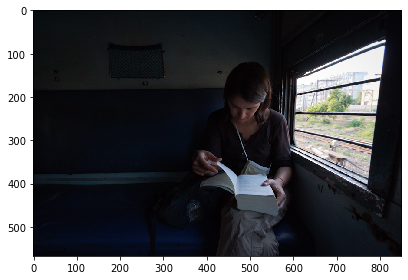

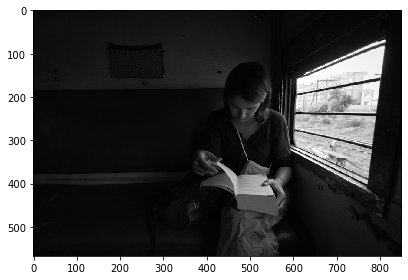

In [6]:
imgIn = imread('train.jpg')
plt.figure()
io.imshow(imgIn)
img1 = color.rgb2yuv(imgIn)
imgInGray = img_as_ubyte(img1[:,:,0])
plt.figure()
io.imshow(imgInGray)

Napravio sam 2 funkcije za histogram u zavisnosti od toga da li je u pitanju rgb ili gray scale slika. Narvno to je moglo da se odradi samo sa jednom funkcijom koja određuje samo za gray scale pa da pozovemo 3 puta kada određujemo za rgb, ali mi se ovo činilo kao bolje rešenje.

In [7]:
def makeHist2D(imgIn: np.array) -> np.array:
    """

    Parameters
    ----------
    imgIn : np.array
        Input image- gray scale.

    Returns
    -------
    np.array
        Histogram of the gray scale image.

    """
    numHist = np.zeros(256, dtype = float)
    for i in range(0, 256):
        numHist[i] = np.sum(imgIn == i)
    return numHist/imgIn.size

def makeHist3D(imgIn: np.array) -> np.array:
    """

    Parameters
    ----------
    imgIn : np.array
        Input image- rgb.

    Returns
    -------
    np.array
        Return 3 histograms for each component of rgb image.

    """
    numHist = np.zeros([256,3], dtype = float)
    for i in range(0, 256):
        numHist[i,0]=np.sum(imgIn[:,:,0]==i)
        numHist[i,1]=np.sum(imgIn[:,:,1]==i)
        numHist[i,2]=np.sum(imgIn[:,:,2]==i)
    return numHist/imgIn[:,:,0].size

Rezultati ove dve funkcije predstavljam plotom, jer se ne vidi lepo ako odradim stem.

3.0
1.0


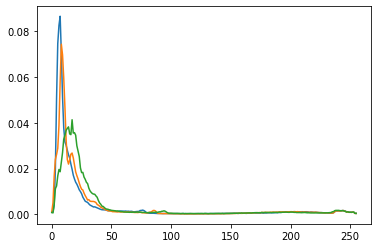

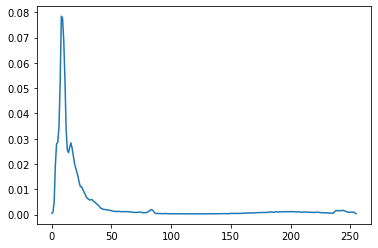

In [8]:
hist=makeHist3D(imgIn)
histGray = makeHist2D(imgInGray)
print(np.sum(hist))
print(np.sum(histGray))
plt.figure()
plt.plot(hist)
plt.figure()
plt.plot(histGray)

Primećujemo da nam slika ima više tamnih piksela nego svetlih. Međutim imamo i mali "pik" i u svetlim pikselima, a to je zbog prozora na slici koji je svetliji od ostatka slike. Zbog toga nam je i potreban CLAHE algoritam da bismo na određenim delovima slike prosvetlili piksele, a na drugim protamnili.

Napisao sam jednu funkciju koja limitira histogram i koja računa funkciju raspodele za dati histogram.

In [9]:
def makeT(histogram: np.array, limit: float) -> np.array:
    """


    Parameters
    ----------
    histogram : np.array
        Values of histogram.
    limit : float
        Limit for histogram.

    Returns
    -------
    T : np.array
        Returns the distribution function and limits the histogram.

    """
    # limiting the histogram
    T1 = np.sum(histogram[histogram > limit])-np.sum(histogram > limit)*limit
    histogram[histogram > limit] = limit
    histogram = histogram + T1/256
    # calculating the distribution function
    T = np.cumsum(histogram)
    # scaling the distribution function
    T = T*255
    return np.floor(T)

Radi lakšeg testiranja iskopiraću deo funkcije koji limitira histogram. Za testiranje koristim samo histogram sa sive slike jer je funkcija napisana tako da zahteva takav niz, a ne matricu. Kada pozivam ovu funkciju za RGB sliku, pozivam je za sve tri komponente R,G i B.

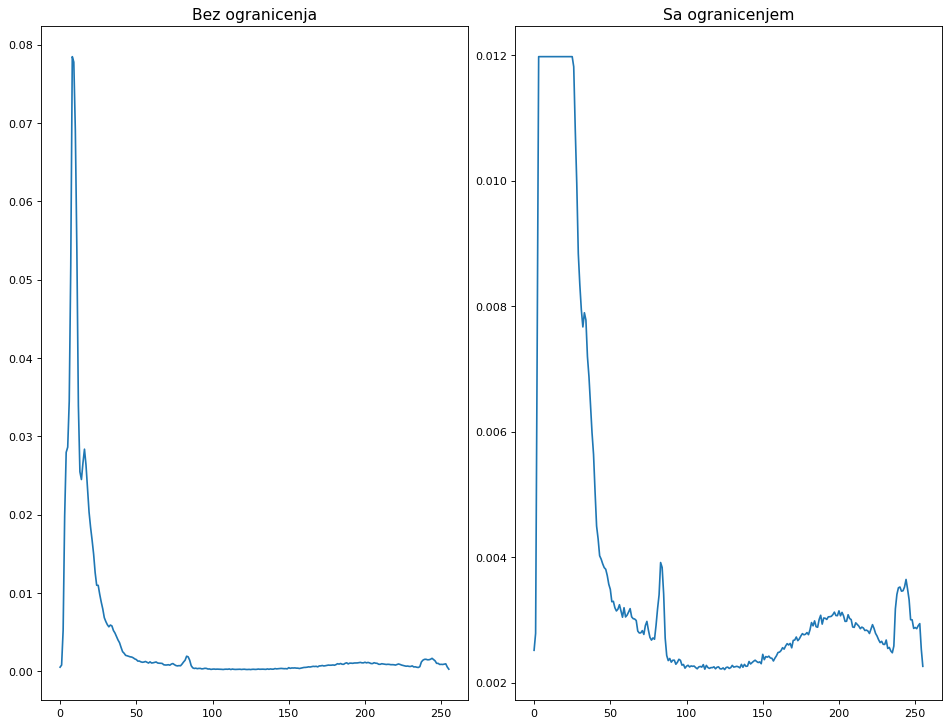

In [10]:
histogram = np.copy(histGray)

limit = 0.01
T1 = np.sum(histogram[histogram > limit])-np.sum(histogram > limit)*limit
histogram[histogram > limit] = limit
histogram = histogram + T1/256
fig, ax = plt.subplots(1, 2, figsize=(12,9), dpi=80);
tight_layout();
ax[0].plot(histGray); ax[0].set_title('Bez ogranicenja', fontsize=14);
ax[1].plot(histogram); ax[1].set_title('Sa ogranicenjem', fontsize=14);

Limitiranje je ograničilo maksimalnu vrednost histograma na 0.01. Time smo postigli da nam histogram bude uniformniji i na taj način smo smanjili šum.

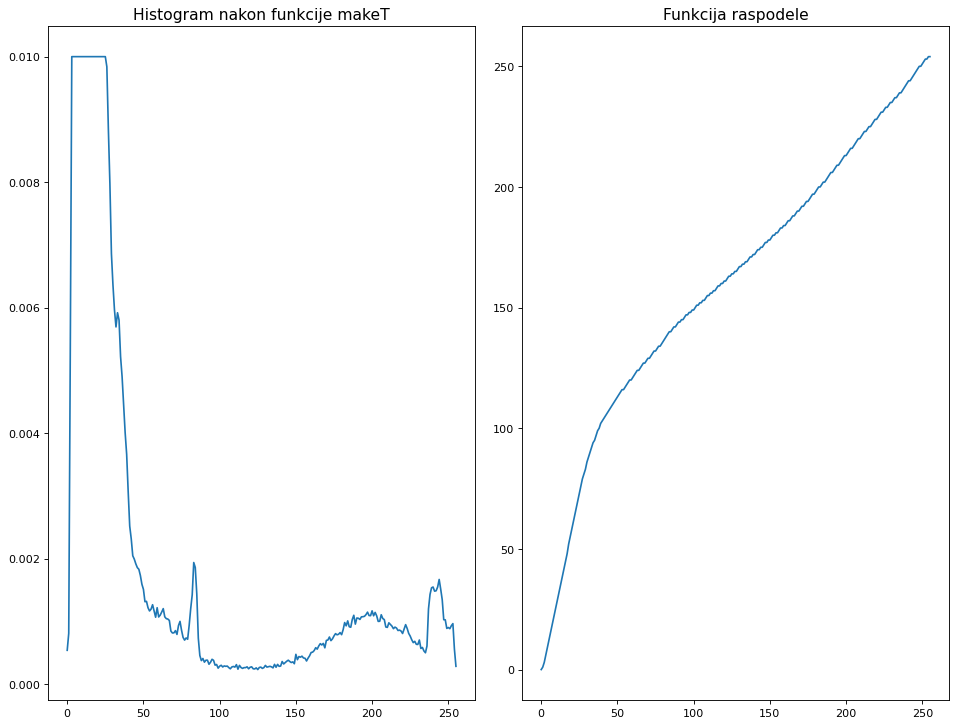

In [11]:
TGray = makeT(histGray, 0.01)

fig, ax = plt.subplots(1, 2, figsize=(12,9), dpi=80);
tight_layout();
ax[0].plot(histGray); ax[0].set_title('Histogram nakon funkcije makeT', fontsize=14);
ax[1].plot(TGray); ax[1].set_title('Funkcija raspodele', fontsize=14);

Napisao sam dve funkcije koje dele sliku na blokove u zavisnosti od toga da li je slika siva ili je RGB. Funkcije kao ulazne parametre uzimaju sliku, veličinu bloka po x i y dimenziji i index bloka po obe dimenzije. Onda ove funkcije pozivam za svaki blok i na taj način određujem deo slike koji se nalazi u (i,j) bloku.

In [12]:
def makeMat3D(imgIn: np.array, sizeX: int, sizeY: int, i: int, j: int) -> np.array:
    """


    Parameters
    ----------
    imgIn : np.array
        Input rgb image.
    sizeX : int
        Size of x coordinate of the tile.
    sizeY : int
        Size of y coordinate of the tile.
    i : int
        Index of the tile.
    j : int
        Index of the tile.
    Returns
    -------
    arr : np.array
        Returns the (i, j) piece of input image

    """
    # if the tile is inside the image
    if (i+1)*sizeX <= imgIn.shape[0] and (j+1)*sizeY <= imgIn.shape[1]:
        return imgIn[i*sizeX:(i+1)*sizeX, j*sizeY:(j+1)*sizeY, :]
    # if the x coordinate extends the boundaries of the image
    if (i+1)*sizeX > imgIn.shape[0] and (j+1)*sizeY <= imgIn.shape[1]:
        mat = imgIn[i*sizeX:, j*sizeY:(j+1)*sizeY, :]
        con = imgIn[imgIn.shape[0]-(i+1)*sizeX:, j*sizeY:(j+1)*sizeY, :]
        return np.concatenate((mat, con), axis=0)
    # if the y coordinate extends the boundaries of the image
    if (i+1)*sizeX <= imgIn.shape[0] and (j+1)*sizeY > imgIn.shape[1]:
        mat = imgIn[i*sizeX:(i+1)*sizeX, j*sizeY:, :]
        con = imgIn[i*sizeX:(i+1)*sizeX, imgIn.shape[1]-(j+1)*sizeY:, :]
        return np.concatenate((mat, con), axis=1)
    # if both x and y coordinate extend the boundaries of the image
    mat = imgIn[i*sizeX:, j*sizeY:, :]
    con1 = imgIn[i*sizeX:, imgIn.shape[1]-(j+1)*sizeY:, :]
    mat = np.concatenate((mat, con1), axis=1)
    con2 = mat[imgIn.shape[0]-(i+1)*sizeX:, :, :]
    return np.concatenate((mat, con2), axis=0)

def makeMat2D(imgIn: np.array, sizeX: int, sizeY: int, i: int, j: int) -> np.array:
    """


    Parameters
    ----------
    imgIn : np.array
        Input gray-scale image.
    sizeX : int
        Size of x coordinate of the tile.
    sizeY : int
        Size of y coordinate of the tile.
    i : int
        Index of the tile.
    j : int
        Index of the tile.
    Returns
    -------
    arr : np.array
        Returns the (i, j) piece of input image

    """
    if (i+1)*sizeX <= imgIn.shape[0] and (j+1)*sizeY <= imgIn.shape[1]:
        return imgIn[i*sizeX:(i+1)*sizeX, j*sizeY:(j+1)*sizeY]
    if (i+1)*sizeX > imgIn.shape[0] and (j+1)*sizeY <= imgIn.shape[1]:
        mat = imgIn[i*sizeX:, j*sizeY:(j+1)*sizeY]
        con = imgIn[imgIn.shape[0]-(i+1)*sizeX:, j*sizeY:(j+1)*sizeY]
        return np.concatenate((mat, con), axis=0)
    if (i+1)*sizeX <= imgIn.shape[0] and (j+1)*sizeY > imgIn.shape[1]:
        mat = imgIn[i*sizeX:(i+1)*sizeX, j*sizeY:]
        con = imgIn[i*sizeX:(i+1)*sizeX, imgIn.shape[1]-(j+1)*sizeY:]
        return np.concatenate((mat, con), axis=1)
    mat = imgIn[i*sizeX:, j*sizeY:]
    con1 = imgIn[i*sizeX:, imgIn.shape[1]-(j+1)*sizeY:]
    mat = np.concatenate((mat, con1), axis=1)
    con2 = mat[imgIn.shape[0]-(i+1)*sizeX:, :]
    return np.concatenate((mat, con2), axis=0)

Ukoliko blok ispadne iz slike, tim blokovima je dodato poslednjih n redova ili kolona na kraj. Nisam vodio računa da bude baš kao slika u ogledalu, jer nam je bitan samo broj piksela, a ne i raspored tih piksela. Test ovih funkcija možete videti u nastavku. 

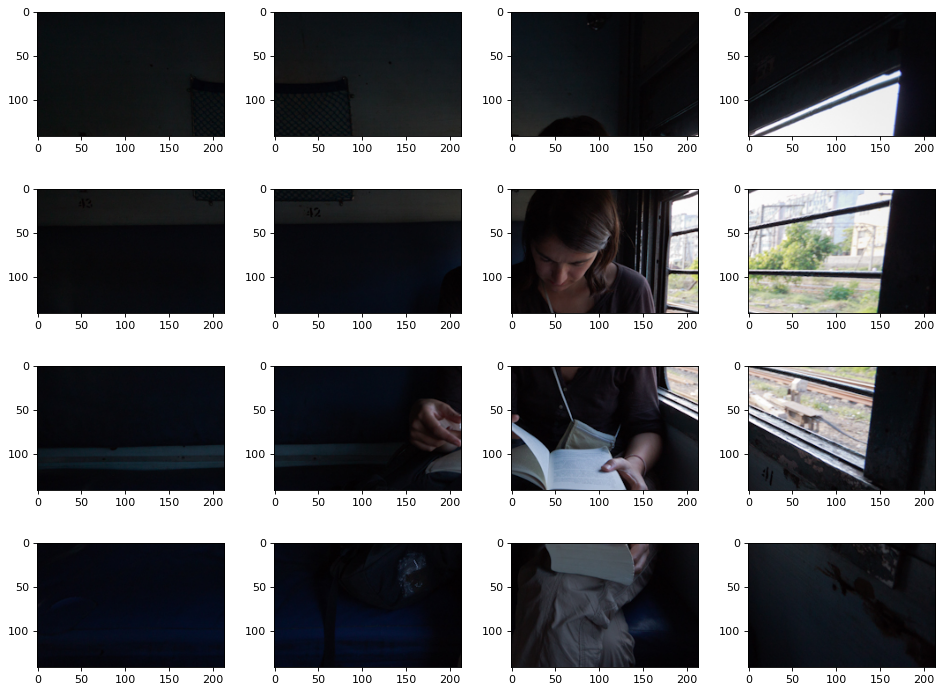

In [13]:
numTiles = [4, 4]

sizeX = math.ceil(imgIn.shape[0]/numTiles[0])
sizeY = math.ceil(imgIn.shape[1]/numTiles[1])

fig, ax = plt.subplots(numTiles[0], numTiles[1], figsize=(12,9), dpi=80);
tight_layout();
for i in range(numTiles[0]):
    for j in range(numTiles[1]):
        img = makeMat3D(imgIn, sizeX, sizeY, i, j)
        ax[i, j].imshow(img);# ax[i, j].set_title('{0},{1}',i,j, fontsize=14);

Za dalje korišćenje bilinearne interpolacije koristio sam funkciju sgn. Kako nisam uspeo da nađem ugrađenu napisao sam svoju.

In [14]:
def sgn(x: int) -> int:
    """


    Parameters
    ----------
    x : int
        Value.

    Returns
    -------
    int
        Sign of x, sign does not important if x is zero.

    """
    if (x < 0):
        return -1
    return 1

Kao poslednji deo ovog algoritma ostala je bilinearna interpolacija. Ovde takođe postoje 2 funkcije u zavisnosti od toga da li je u pitanju siva slika ili RGB.

In [15]:
def bilinearInterpolation3D(imgIn: np.array, T: np.array, sizeX: int, sizeY: int, numTiles: []) -> np.array:
    """


    Parameters
    ----------
    imgIn : np.array
        Input rgb image.
    T : np.array
        Matrix of distribution functions for each tile.
    sizeX : int
        Number of pixcels in x coordinate for each tile.
    sizeY : int
        Number of pixcels in y coordinate for each tile.
    numTiles : []
        Number of tiles.

    Returns
    -------
    imgOut : np.array
        Calculates values of each pixcel using bilinear interpolation.

    """
    imgOut = np.zeros(imgIn.shape, dtype=uint8)
    # calculating bilinear interpolation for every pixcel
    for i in range(imgIn.shape[0]):
        for j in range(imgIn.shape[1]):
            # finding in which tile is pixcel
            blockX = math.floor(i/sizeX)
            blockY = math.floor(j/sizeY)
            # finding the center of the tile
            centerX = sizeX/2 + blockX*sizeX
            centerY = sizeY/2 + blockY*sizeY
            # finding other tiles for bilinear interpolation
            pomX = sgn(i-centerX)
            pomY = sgn(j-centerY)
            # finding the weights a and b
            a = abs(i-centerX)
            b = abs(i-(centerX+pomX*sizeX))

            x1 = np.array([0, 0, 0])
            x2 = np.array([0, 0, 0])
            x3 = np.array([0, 0, 0])
            # if these tiles are out of the image, some weights are equal to 0
            if blockX+pomX < 0 or (blockX+pomX) >= numTiles[0]:
                a = 0
            else:
                x10 = T[blockX+pomX, blockY, imgIn[i, j, 0], 0]
                x11 = T[blockX+pomX, blockY, imgIn[i, j, 1], 1]
                x12 = T[blockX+pomX, blockY, imgIn[i, j, 2], 2]
                x1 = np.array([x10, x11, x12])

            if blockY+pomY >= 0 and (blockY+pomY) < numTiles[1]:
                x20 = T[blockX, blockY+pomY, imgIn[i, j, 0], 0]
                x21 = T[blockX, blockY+pomY, imgIn[i, j, 1], 1]
                x22 = T[blockX, blockY+pomY, imgIn[i, j, 2], 2]
                x2 = np.array([x20, x21, x22])
                if blockX+pomX >= 0 and (blockX+pomX) < numTiles[0]:
                    x30 = T[blockX+pomX, blockY+pomY, imgIn[i, j, 0], 0]
                    x31 = T[blockX+pomX, blockY+pomY, imgIn[i, j, 1], 1]
                    x32 = T[blockX+pomX, blockY+pomY, imgIn[i, j, 2], 2]
                    x3 = np.array([x30, x31, x32])

            c = abs(j-centerY)
            d = abs(j-(centerY+pomY*sizeY))

            if blockY+pomY < 0 or (blockY+pomY) >= numTiles[1]:
                c = 0
            # calculating the r, g and b component of the auxiliary pixcels
            sh10 = (T[blockX, blockY, imgIn[i, j, 0], 0]*b + x1[0]*a)/(a+b)

            sh11 = (T[blockX, blockY, imgIn[i, j, 1], 1]*b + x1[1]*a)/(a+b)

            sh12 = (T[blockX, blockY, imgIn[i, j, 2], 2]*b + x1[2]*a)/(a+b)

            sh1 = np.array([sh10, sh11, sh12])
            sh2 = (x2*b+x3*a)/(a+b)
            # caluclating the output pixcel
            imgOut[i, j, :] = np.round((sh1*d+sh2*c)/(c+d))

    return imgOut

def bilinearInterpolation2D(imgIn: np.array, T: np.array, sizeX: int, sizeY: int, numTiles: []) -> np.array:
    """


    Parameters
    ----------
    imgIn : np.array
        Input gray-scale image.
    T : np.array
        Matrix of distribution functions for each tile.
    sizeX : int
        Number of pixcels in x coordinate for each tile.
    sizeY : int
        Number of pixcels in y coordinate for each tile.
    numTiles : []
        Number of tiles.

    Returns
    -------
    imgOut : np.array
        Calculates values of each pixcel using bilinear interpolation.

    """
    imgOut = np.zeros(imgIn.shape, dtype=uint8)
    # calculating bilinear interpolation for every pixcel
    for i in range(imgIn.shape[0]):
        for j in range(imgIn.shape[1]):
            # finding in which tile is pixcel
            blockX = math.floor(i/sizeX)
            blockY = math.floor(j/sizeY)
            # finding the center of the tile
            centerX = sizeX/2 + blockX*sizeX
            centerY = sizeY/2 + blockY*sizeY
            # finding other tiles for bilinear interpolation
            pomX = sgn(i-centerX)
            pomY = sgn(j-centerY)
            # finding the weights a and b
            a = abs(i-centerX)
            b = abs(i-(centerX+pomX*sizeX))
            
            x1 = 0
            x2 = 0
            x3 = 0
            # if these tiles are out of the image, some weights are equal to 0
            if blockX+pomX < 0 or (blockX+pomX) >= numTiles[0]:
                a = 0
            else:
                x1 = T[blockX+pomX, blockY, imgIn[i, j]]

            if blockY+pomY >= 0 and (blockY+pomY) < numTiles[1]:
                x2 = T[blockX, blockY+pomY, imgIn[i, j]]
                if blockX+pomX >= 0 and (blockX+pomX) < numTiles[0]:
                    x3 = T[blockX+pomX, blockY+pomY, imgIn[i, j]]

            c = abs(j-centerY)
            d = abs(j-(centerY+pomY*sizeY))

            if blockY+pomY < 0 or (blockY+pomY) >= numTiles[1]:
                c = 0
            # calculating the r, g and b component of the auxiliary pixcels
            sh1 = (T[blockX, blockY, imgIn[i, j]]*b + x1*a)/(a+b)
            sh2 = (x2*b+x3*a)/(a+b)
            # caluclating the output pixcel
            imgOut[i, j] = np.round((sh1*d+sh2*c)/(c+d))

    return imgOut

Ovu funkciju nisam siguran kako da testiram, pa zbog toga ću pokazati samo funkciju dosCLAHE i njene rezultate.

In [16]:
def dosCLAHE(imgIn: np.array, numTiles: [] = [8, 8], limit: float = 0.01) -> np.array:
    """


    Parameters
    ----------
    imgIn : np.array
        Input image.
    numTiles : [], optional
        Number of tiles. The default is [8, 8].
    limit : float, optional
        Clip limit for histogram values. The default is 0.01.

    Returns
    -------
    np.array
        Returns tha image processed by CLAHE algorithm.

    """
    # calculating the size of each tile
    sizeX = math.ceil(imgIn.shape[0]/numTiles[0])
    sizeY = math.ceil(imgIn.shape[1]/numTiles[1])
    # exceptions
    if limit <= 0:
        print("Greska sa limitom.")
        return

    if len(numTiles) != 2 or numTiles[0] <= 0 or numTiles[1] <= 0 or type(numTiles[0]) is not int or type(numTiles[1]) is not int:
        print("Greska sa blokovima.")
        return

    # enters the if if the image is rgb, otherwise it is gray scale
    if len(imgIn.shape) == 3:
        T = np.zeros([numTiles[0], numTiles[1], 256, 3])
        # calculate the histogram and distribution function for each tile
        for i in range(numTiles[0]):
            for j in range(numTiles[1]):
                mat = makeMat3D(imgIn, sizeX, sizeY, i, j)
                histogram = makeHist3D(mat)
                T[i, j, :, 0] = makeT(histogram[:, 0], limit)
                T[i, j, :, 1] = makeT(histogram[:, 1], limit)
                T[i, j, :, 2] = makeT(histogram[:, 2], limit)

        return bilinearInterpolation3D(imgIn, T, sizeX, sizeY, numTiles)
    else:
        T = np.zeros([numTiles[0], numTiles[1], 256])
        # calculate the histogram and distribution function for each tile
        for i in range(numTiles[0]):
            for j in range(numTiles[1]):
                mat = makeMat2D(imgIn, sizeX, sizeY, i, j)
                histogram = makeHist2D(mat)
                T[i, j, :] = makeT(histogram, limit)
        return bilinearInterpolation2D(imgIn, T, sizeX, sizeY, numTiles)


Ova funkcija je spojila sve one funkcije u jednu i na taj način generisala algoritam dosCLAHE. Od ulaznih parametara sam stavio ograničio da limit mora da bude pozitivan i da broj blokova mora da bude ceo broj, kao i pogrešne dimenzije liste numTiles.

Vreme izvrsavanja i za sivu i za RGB sliku: 21.921s 



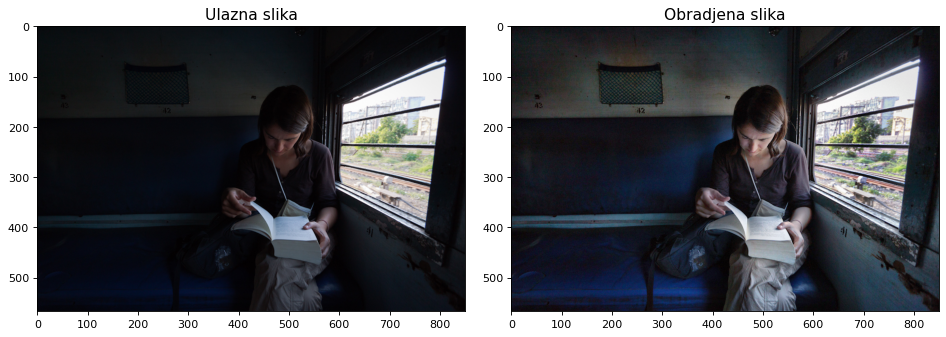

<Figure size 432x288 with 0 Axes>

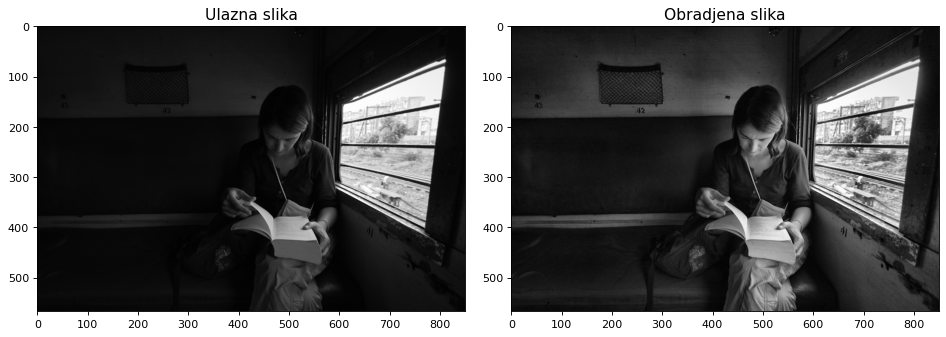

In [21]:
executionTime = [0, 0]
startTime = time.time()
imgOut = dosCLAHE(imgIn)
end_time = time.time()
executionTime[0] = endTime - startTime
startTime = time.time()
imgOutGray = dosCLAHE(imgInGray)
end_time = time.time()
executionTime[1] = endTime - startTime


if type(imgOut) is np.ndarray:
    fig, ax = plt.subplots(1, 2, figsize=(12,9), dpi=80);
    tight_layout();
    ax[0].imshow(imgIn); ax[0].set_title('Ulazna slika', fontsize=14);
    ax[1].imshow(imgOut); ax[1].set_title('Obradjena slika', fontsize=14);
    print("Vreme izvrsavanja za RGB sliku: " + str(round(executionTime[0], 3)) + "s \n")

if type(imgOutGray) is np.ndarray:
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12,9), dpi=80);
    tight_layout();
    ax[0].imshow(imgInGray, cmap='gray'); ax[0].set_title('Ulazna slika', fontsize=14);
    ax[1].imshow(imgOutGray, cmap='gray'); ax[1].set_title('Obradjena slika', fontsize=14);
    print("Vreme izvrsavanja za RGB sliku: " + str(round(executionTime[1], 3)) + "s \n")